# New Concept

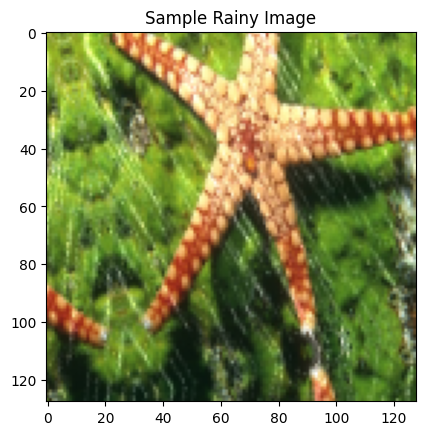

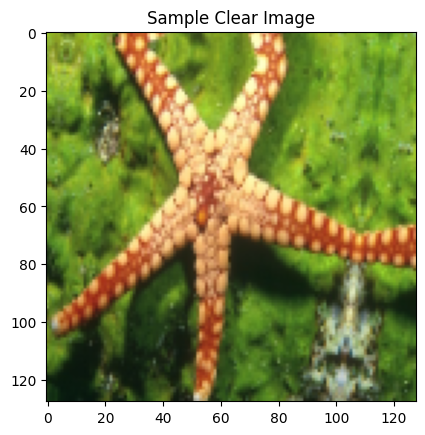

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64, 64, 3) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 32, 32, 3) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 128, 128,  │         30 │ lambda[0][0]      │
│ (DepthwiseConv2D)   │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 64, 64, 3) │         51 │ lambda_2[0][0]    │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 32, 32, 3) │         78 │ lambda_4[0][0]    │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        256 │ depthwise_conv2d… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        256 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │        512 │ depthwise_conv2d… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │        512 │ lambda_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      1,024 │ depthwise_conv2d… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      1,024 │ lambda_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d[0][0],     │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_2[0][0],   │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ conv2d_4[0][0],   │
│                     │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 28,985,474 (110.57 MB)

 Trainable params: 28,985,474 (110.57 MB)

 Non-trainable params: 0 (0.00 B)

Dataset Size: 3600
Steps per Epoch: 900
Epoch 1/50


I0000 00:00:1727412388.326042     101 service.cc:145] XLA service 0x7f26340050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727412388.326102     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727412388.326107     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727412388.672762     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_36/4276896839.py", line 296, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Out of memory while trying to allocate 34376515584 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_72773]

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Optionally, force CPU for debugging
# tf.config.set_visible_devices([], 'GPU')

# Disable XLA to avoid issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        
        # Use Depthwise Separable Convolutions
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)  # Pointwise Conv
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Swin Transformer Block Implementation with k-th Attention
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k  # Number of top-k attention weights
        self.dim = dim
        
        # Layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        
        # Multi-head self-attention
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        
        # Feed-forward network
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])
    
    def call(self, x):
        # Layer normalization
        x_norm = self.norm1(x)

        # Compute attention
        attn_output = self.attn(x_norm, x_norm)

        # Get top-k attention weights
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))  # Computing attention weights
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)

        # Suppress weights below the threshold
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)

        # Normalize the weights again after thresholding
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)

        # Use the modified attention weights to compute output
        attn_output = tf.matmul(attn_weights, attn_output)

        # Skip connection
        x = x + attn_output  

        # Feed-forward network
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  # Skip connection
        
        return x

def swin_transformer_block(inputs):
    # Define parameters for the Swin Transformer Block
    dim = inputs.shape[-1]  # Input channel dimension
    num_heads = 4  # Number of attention heads
    window_size = 7  # Size of the window
    shift_size = 0  # Shift size for the windowing scheme
    
    # Create the Swin Transformer Block
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4, shift_size=shift_size)(inputs)
    
    return x

# Recursive Swin Transformer Block with residual connections
def recursive_swin_transformer_block(inputs, num_recursions=6):
    x = inputs
    for _ in range(num_recursions):
        # Call the Swin Transformer block
        x = swin_transformer_block(x)
    
    return x

# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(inputs, num_classes=3):
    # Normalize the input features
    x = LayerNormalization()(inputs)
    
    # Using Depthwise Separable Convolutions
    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(x)
    
    return x

# Full Model Creation
def build_full_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Dynamic Pyramid Model
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)

    # Recursive Swin Transformer Block
    transformer_features = recursive_swin_transformer_block(pyramid_features)

    # Image Restoration and Enhancement
    outputs = image_restoration_and_enhancement(transformer_features, num_classes=input_shape[-1])

    return Model(inputs=inputs, outputs=outputs)

# Load dataset
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

# Show some example images to verify data loading
plt.imshow(rainy_train[0])
plt.title("Sample Rainy Image")
plt.show()

plt.imshow(clear_train[0])
plt.title("Sample Clear Image")
plt.show()

# Build the model
input_shape = rainy_train[0].shape  # Assuming your input images are all the same size
model = build_full_model(input_shape)
model.summary()

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Proper TensorFlow logging
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

# Custom callback to print CPU/GPU usage
class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Print resource information at the beginning of each epoch
        print(f"Epoch {epoch + 1} starting...")
        
        # Check CPU utilization
        cpu_info = os.popen("lscpu").read()
        print(f"CPU Info:\n{cpu_info}")
        
        # Check GPU utilization if available
        if tf.config.list_physical_devices('GPU'):
            gpu_info = os.popen("nvidia-smi").read()
            print(f"GPU Info:\n{gpu_info}")
        else:
            print("No GPU detected, using CPU.")
        
    def on_epoch_end(self, epoch, logs=None):
        # Summary of the epoch
        print(f"Epoch {epoch + 1} ended. Loss: {logs.get('loss')}, Validation Loss: {logs.get('val_loss')}")
        print("=" * 50)

# Ensure the dataset isn't infinite
batch_size = 4
steps_per_epoch = len(rainy_train) // batch_size  # Ensure steps per epoch is finite

# Add debug prints in your data preprocessing and training loops
print(f"Dataset Size: {len(rainy_train)}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    rainy_train, clear_train,
    validation_data=(rainy_test, clear_test),
    epochs=50,
    batch_size=8,  # Change this value if necessary
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Evaluate the model
mse = mean_squared_error(clear_test.flatten(), model.predict(rainy_test).flatten())
print("Mean Squared Error on Test Set: ", mse)

# You can also calculate SSIM
ssim_value = ssim(clear_test[0], model.predict(rainy_test)[0], multichannel=True)
print("SSIM Value on Test Set: ", ssim_value)


# Without Swin

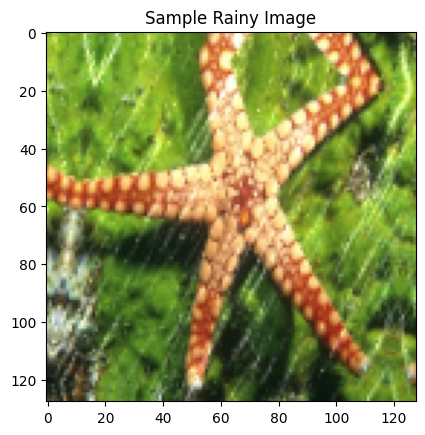

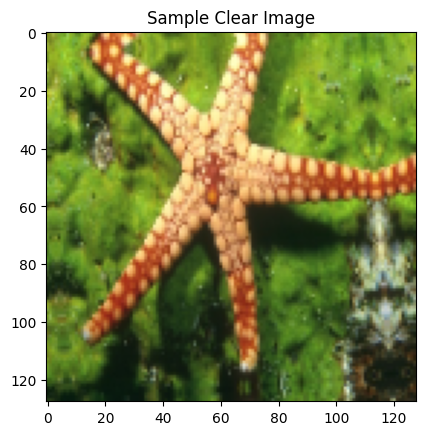

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, 128, 128,  │          0 │ input_layer_13[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, 64, 64, 3) │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_25 (Lambda)  │ (None, 32, 32, 3) │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_15 │ (None, 128, 128,  │         30 │ lambda_21[0][0]   │
│ (DepthwiseConv2D)   │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_16 │ (None, 64, 64, 3) │         51 │ lambda_23[0][0]   │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_17 │ (None, 32, 32, 3) │         78 │ lambda_25[0][0]   │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │        256 │ depthwise_conv2d… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │        256 │ lambda_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │        512 │ depthwise_conv2d… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │        512 │ lambda_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │      1,024 │ depthwise_conv2d… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │      1,024 │ lambda_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 128, 128,  │          0 │ conv2d_27[0][0],  │
│                     │ 64)               │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 64,    │          0 │ conv2d_29[0][0],  │
│                     │ 128)              │            │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 32, 32,    │          0 │ conv2d_31[0][0],  │
│                     │ 256)              │            │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_22 (Lambda)  │ (None, 128, 128,  │          0 │ add_9[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,962 (97.51 KB)

 Trainable params: 24,962 (97.51 KB)

 Non-trainable params: 0 (0.00 B)

Dataset Size: 3600
Steps per Epoch: 900
Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5047 - loss: 0.0478 - val_accuracy: 0.8110 - val_loss: 0.0298
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6908 - loss: 0.0391 - val_accuracy: 0.7897 - val_loss: 0.0308
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6992 - loss: 0.0387 - val_accuracy: 0.8342 - val_loss: 0.0298
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7051 - loss: 0.0383 - val_accuracy: 0.8150 - val_loss: 0.0309
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7070 - loss: 0.0384 - val_accuracy: 0.8127 - val_loss: 0.0343
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7045 - loss: 0.0388 - val_accuracy: 0.8288 - val_loss: 0.0311
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7083 - loss: 0.0376 - val_accuracy: 0.8325 - val_loss: 0.0299
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/s

ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

In [4]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, DepthwiseConv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from tensorflow.image import psnr  # Importing TensorFlow's PSNR function

# Optionally, force CPU for debugging
# tf.config.set_visible_devices([], 'GPU')

# Disable XLA to avoid issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        
        # Use Depthwise Separable Convolutions
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)  # Pointwise Conv
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(inputs, num_classes=3):
    # Normalize the input features
    x = LayerNormalization()(inputs)
    
    # Using Depthwise Separable Convolutions
    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(x)
    
    return x

# Full Model Creation
def build_full_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Dynamic Pyramid Model
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)

    # Image Restoration and Enhancement
    outputs = image_restoration_and_enhancement(pyramid_features, num_classes=input_shape[-1])

    return Model(inputs=inputs, outputs=outputs)

# Load dataset
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

# Show some example images to verify data loading
plt.imshow(rainy_train[0])
plt.title("Sample Rainy Image")
plt.show()

plt.imshow(clear_train[0])
plt.title("Sample Clear Image")
plt.show()

# Build the model
input_shape = rainy_train[0].shape  # Assuming your input images are all the same size
model = build_full_model(input_shape)
model.summary()

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Proper TensorFlow logging
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

# Custom callback to print CPU/GPU usage
class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Print resource information at the beginning of each epoch
        print(f"Epoch {epoch + 1} starting...")
        
        # Check CPU utilization
        cpu_info = os.popen("lscpu").read()
        print(f"CPU Info:\n{cpu_info}")
        
        # Check GPU utilization if available
        if tf.config.list_physical_devices('GPU'):
            gpu_info = os.popen("nvidia-smi").read()
            print(f"GPU Info:\n{gpu_info}")
        else:
            print("No GPU detected, using CPU.")
        
    def on_epoch_end(self, epoch, logs=None):
        # Summary of the epoch
        print(f"Epoch {epoch + 1} ended. Loss: {logs.get('loss')}, Validation Loss: {logs.get('val_loss')}")
        print("=" * 50)

# Ensure the dataset isn't infinite
batch_size = 4
steps_per_epoch = len(rainy_train) // batch_size  # Ensure steps per epoch is finite

# Add debug prints in your data preprocessing and training loops
print(f"Dataset Size: {len(rainy_train)}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    rainy_train, clear_train,
    validation_data=(rainy_test, clear_test),
    epochs=50,
    batch_size=8,  # Change this value if necessary
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Evaluate the model
predicted_images = model.predict(rainy_test)

# Calculate MSE
mse = mean_squared_error(clear_test.flatten(), predicted_images.flatten())
print("Mean Squared Error on Test Set: ", mse)

# Calculate PSNR
psnr_value = tf.reduce_mean(psnr(clear_test, predicted_images, max_val=1.0))
print("PSNR on Test Set: ", psnr_value.numpy())

# Calculate SSIM (with win_size <= 7, and using channel_axis instead of multichannel)
ssim_values = []
for i in range(len(clear_test)):
    ssim_value = ssim(clear_test[i], predicted_images[i], win_size=5, channel_axis=-1)  # Set win_size <= 7
    ssim_values.append(ssim_value)

avg_ssim_value = np.mean(ssim_values)
print("Average SSIM on Test Set: ", avg_ssim_value)


# Training

In [8]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Disable XLA to avoid issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        print(f"Loaded image shape: {img_resized.shape}")  # Print loaded image shape
        images.append(img_resized)
    return np.array(images)

def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)
        print(f"Augmented image shape: {augmented_images.shape}")  # Print augmented image shape
        return augmented_images
    return images

def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    print(f"Train rainy images shape: {rainy_images_train.shape}")
    print(f"Train clear images shape: {clear_images_train.shape}")
    print(f"Test rainy images shape: {rainy_images_test.shape}")
    print(f"Test clear images shape: {clear_images_test.shape}")

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

def advanced_dynamic_pyramid_model(input_shape, num_scales=2):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)

        print(f"Scale {scale} input shape: {x_scaled.shape}")  # Print shape after scaling
        
        kernel_size = 3 + scale
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        
        print(f"Depthwise conv shape (scale {scale}): {x_conv.shape}")  # Print shape after depthwise conv
        
        x_conv = Conv2D(32 * scale_factor, (1, 1), padding='same')(x_conv)

        x_scaled_conv = Conv2D(32 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])

        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        print(f"Resized conv shape (scale {scale}): {x_resized.shape}")  # Print shape after resizing
        
        pyramid_features.append(x_resized)

    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    print(f"Pyramid fused features shape: {fused_features.shape}")  # Print shape of fused features
    
    return inputs, fused_features

class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=2, shift_size=0, mlp_ratio=2.):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k
        self.dim = dim
        
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])
    
    def call(self, x):
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm, x_norm)

        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)

        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)

        attn_output = tf.matmul(attn_weights, attn_output)
        x = x + attn_output  

        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  
        
        return x

def swin_transformer_block(inputs):
    dim = inputs.shape[-1] 
    num_heads = 2  
    window_size = 7  
    shift_size = 0  
    
    return SwinTransformerBlock(dim, num_heads, window_size, k=2, shift_size=shift_size)(inputs)

def recursive_swin_transformer_block(inputs, num_recursions=3):
    x = inputs
    for _ in range(num_recursions):
        x = swin_transformer_block(x)
        print(f"After SWIN block recursion shape: {x.shape}")  # Print shape after each recursion
    
    return x

def image_restoration_and_enhancement(input_shape, num_classes=3):
    inputs = Input(shape=input_shape)
    x = LayerNormalization()(inputs)
    _, pyramid_features = advanced_dynamic_pyramid_model(input_shape)  
    x = recursive_swin_transformer_block(pyramid_features, num_recursions=3)
    
    print(f"Post SWIN Block Shape: {x.shape}")  # Print shape after the SWIN block
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    print(f"After final Conv2D shape: {x.shape}")  # Print shape after the final Conv2D
    
    x = Dropout(0.1)(x)  
    x = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(x)
    print(f"Final output shape: {x.shape}")  # Print final output shape
    
    return x

# Build model
input_shape = (128, 128, 3)  
outputs = image_restoration_and_enhancement(input_shape)
model = Model(inputs=Input(shape=input_shape), outputs=outputs)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
early_stop = EarlyStopping(patience=5)

# Load datasets
base_folder = '/kaggle/input/derainingdata/RainData'  # Adjust this path
augment = True
(train_images, clear_images), (test_images, clear_images_test) = load_and_preprocess_datasets(base_folder, augment=augment)

# Train model
history = model.fit(train_images, clear_images, epochs=100, validation_data=(test_images, clear_images_test), 
                    callbacks=[checkpoint, early_stop])

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, clear_images_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")


Scale 0 input shape: (None, 128, 128, 3)
Depthwise conv shape (scale 0): (None, 128, 128, 3)
Resized conv shape (scale 0): (None, 128, 128, 32)
Scale 1 input shape: (None, 64, 64, 3)
Depthwise conv shape (scale 1): (None, 64, 64, 3)
Resized conv shape (scale 1): (None, 128, 128, 64)
Pyramid fused features shape: (None, 128, 128, 96)
After SWIN block recursion shape: (None, 128, 128, 96)
After SWIN block recursion shape: (None, 128, 128, 96)
After SWIN block recursion shape: (None, 128, 128, 96)
Post SWIN Block Shape: (None, 128, 128, 96)
After final Conv2D shape: (None, 128, 128, 32)
Final output shape: (None, 128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128, 3)
Loaded image shape: (128, 128

KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m139150976025072\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)\n  • training=True\n  • mask=None'

# Pruned model

In [3]:
!pip install tensorflow-model-optimization

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 6, in <module>
    from pip._internal.cli.main import main
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/ut

In [4]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_model_optimization as tfmot
from tensorflow.keras.losses import KLDivergence

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    """
    Loads and resizes images from a specified folder.

    Args:
        folder (str): Path to the folder containing images.
        size (tuple): Desired size for resizing the images (width, height).

    Returns:
        np.array: Array of loaded and resized images.
    """
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    """
    Preprocess and augment image data.

    Args:
        images (np.array): Array of images to preprocess.
        augment (bool): If True, applies augmentation to the images.

    Returns:
        np.array: Preprocessed (and possibly augmented) images.
    """
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    """
    Loads and preprocesses the dataset for training and testing.

    Args:
        base_folder (str): Path to the base folder containing datasets.
        size (tuple): Desired size for resizing the images.
        augment (bool): If True, applies data augmentation to training data.

    Returns:
        tuple: Training and testing datasets for rainy and clear images.
    """
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    """
    Builds an advanced dynamic pyramid model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_scales (int): Number of scales for the pyramid model.

    Returns:
        tuple: Model input and concatenated pyramid features.
    """
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        kernel_size = 3 + scale
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        pyramid_features.append(x_resized)

    fused_features = Lambda(lambda x: tf.concat(x, axis=-1))(pyramid_features)
    return inputs, fused_features

# Swin Transformer Block
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        """
        Swin Transformer Block with top-k sparsity applied.

        Args:
            dim (int): Input dimension size.
            num_heads (int): Number of attention heads.
            window_size (int): Size of the local attention window.
            k (int): Top-k sparsity parameter.
            shift_size (int): Shift size for shifted windowing.
            mlp_ratio (float): Ratio for the MLP hidden size.
        """
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k
        self.dim = dim
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])

    def call(self, x):
        """
        Applies Swin transformer block with top-k sparsity attention.

        Args:
            x: Input tensor.

        Returns:
            Tensor after applying attention and MLP.
        """
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm, x_norm)
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)
        attn_output = tf.matmul(attn_weights, attn_output)
        x = x + attn_output  
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  
        return x

# Swin Transformer block helper functions
def swin_transformer_block(inputs):
    dim = inputs.shape[-1]
    num_heads = 4
    window_size = 7
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4)(inputs)
    return x

def recursive_swin_transformer_block(inputs, num_recursions=6):
    """
    Builds a recursive Swin transformer block for multiple recursions.

    Args:
        inputs: Input tensor.
        num_recursions (int): Number of recursive blocks to apply.

    Returns:
        Output tensor after multiple recursions.
    """
    x = inputs
    for _ in range(num_recursions):
        x = swin_transformer_block(x)
    return x

# Image Restoration and Enhancement Block with Dropout
def image_restoration_and_enhancement_with_dropout(inputs, num_classes=3, dropout_rate=0.4):
    """
    Image restoration and enhancement block with dropout layers.

    Args:
        inputs: Input tensor.
        num_classes (int): Number of output channels.
        dropout_rate (float): Dropout rate to apply.

    Returns:
        Output tensor for image restoration and enhancement.
    """
    x = LayerNormalization()(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    return x

# Build the complete model with pyramid, Swin transformer, and enhancement block
def build_full_model_with_dropout(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.4):
    """
    Builds the complete image restoration model with dropout, dynamic pyramid, and Swin transformer.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_classes (int): Number of output channels.
        dropout_rate (float): Dropout rate to apply in the enhancement block.

    Returns:
        Model: Keras Model object.
    """
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = recursive_swin_transformer_block(pyramid_features)
    output = image_restoration_and_enhancement_with_dropout(swin_output, num_classes=num_classes, dropout_rate=dropout_rate)
    model = Model(inputs=inputs, outputs=output)

    # Model summary
    model.summary()
    return model

# Knowledge Distillation Loss Function
def knowledge_distillation_loss(student_logits, teacher_logits, alpha=0.5, temperature=3):
    """
    Custom loss function for knowledge distillation.

    Args:
        student_logits: Output logits from the student model.
        teacher_logits: Output logits from the teacher model.
        alpha (float): Weight for balancing between hard target loss and soft target loss.
        temperature (float): Temperature for scaling logits during distillation.

    Returns:
        Loss value.
    """
    distillation_loss = KLDivergence()(tf.nn.softmax(teacher_logits / temperature),
                                       tf.nn.softmax(student_logits / temperature)) * (temperature ** 2)
    return distillation_loss

# Build a smaller student model
def build_student_model(input_shape=(128, 128, 3), dropout_rate=0.4):
    """
    Builds a smaller student model for knowledge distillation.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        dropout_rate (float): Dropout rate to apply in the enhancement block.

    Returns:
        Model: Keras Model object.
    """
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = recursive_swin_transformer_block(pyramid_features, num_recursions=3)  # Fewer recursions for student
    output = image_restoration_and_enhancement_with_dropout(swin_output, dropout_rate=dropout_rate)
    student_model = Model(inputs=inputs, outputs=output)

    # Model summary
    student_model.summary()
    return student_model

# Pruning with TensorFlow Model Optimization Toolkit
def apply_pruning(model):
    """
    Applies pruning to the given model to reduce its size.

    Args:
        model: Keras Model to prune.

    Returns:
        pruned_model: Pruned Keras model.
    """
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.5,
            begin_step=2000, end_step=10000
        )
    }
    pruned_model = prune_low_magnitude(model, **pruning_params)
    pruned_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Model summary
    pruned_model.summary()
    return pruned_model

# Custom training loop for Knowledge Distillation
def train_student_with_distillation(student_model, teacher_model, rainy_train, clear_train, epochs=50, batch_size=32):
    """
    Trains the student model using knowledge distillation from the teacher model.

    Args:
        student_model: Keras model for the student.
        teacher_model: Trained teacher model.
        rainy_train: Training set inputs (rainy images).
        clear_train: Training set targets (clear images).
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch in range(0, len(rainy_train), batch_size):
            x_batch = rainy_train[batch:batch + batch_size]
            y_batch = clear_train[batch:batch + batch_size]
            teacher_logits = teacher_model.predict(x_batch)
            with tf.GradientTape() as tape:
                student_logits = student_model(x_batch)
                loss = knowledge_distillation_loss(student_logits, teacher_logits)
            gradients = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

# Example usage:

# Load data
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, augment=True)

# Train Teacher Model
teacher_model = build_full_model_with_dropout(input_shape=(128, 128, 3), dropout_rate=0.4)
teacher_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
teacher_model.fit(rainy_train, clear_train, epochs=50, batch_size=32, validation_split=0.1)

# Apply Pruning
pruned_teacher_model = apply_pruning(teacher_model)

# Train Student Model using Knowledge Distillation
student_model = build_student_model(input_shape=(128, 128, 3), dropout_rate=0.4)
student_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
train_student_with_distillation(student_model, pruned_teacher_model, rainy_train, clear_train, epochs=50, batch_size=32)


ModuleNotFoundError: No module named 'tensorflow_model_optimization'

# Model with feature aggregation in swin transformer

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)
        return augmented_images
    return images

# Function to load datasets from base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        kernel_size = 3 + scale
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        pyramid_features.append(x_resized)

    fused_features = Lambda(lambda x: tf.concat(x, axis=-1))(pyramid_features)
    return inputs, fused_features

# Swin Transformer Block
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k
        self.dim = dim
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])

    def call(self, x):
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm, x_norm)
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)
        attn_output = tf.matmul(attn_weights, attn_output)
        x = x + attn_output  
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  
        return x

# Swin Transformer block helper functions
def swin_transformer_block(inputs):
    dim = inputs.shape[-1]
    num_heads = 4
    window_size = 7
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4)(inputs)
    return x

# Recursive Swin Transformer Block with Aggregation and Residual Connections
def recursive_swin_transformer_block(inputs, num_recursions=6):
    x = inputs
    for i in range(num_recursions):
        swin_output = swin_transformer_block(x)
        x = Add()([x, swin_output])  # Residual connection across blocks
    return x

# Image Restoration and Enhancement Block with Dropout
def image_restoration_and_enhancement_with_dropout(inputs, num_classes=3, dropout_rate=0.4):
    x = LayerNormalization()(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    return x

# Build the complete model with pyramid, Swin transformer, and enhancement block
def build_full_model_with_dropout(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.4):
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = recursive_swin_transformer_block(pyramid_features)
    output = image_restoration_and_enhancement_with_dropout(swin_output, num_classes=num_classes, dropout_rate=dropout_rate)
    model = Model(inputs=inputs, outputs=output)

    # Model summary
    model.summary()
    return model

# Example usage:

# Load data
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, augment=True)

# Build and compile the full model
model = build_full_model_with_dropout(input_shape=(128, 128, 3), dropout_rate=0.4)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(rainy_train, clear_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
model.evaluate(rainy_test, clear_test)


# Model with hierachical feature map also

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)
        return augmented_images
    return images

# Function to load datasets from base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]),
                          output_shape=(input_shape[0] // scale_factor, input_shape[1] // scale_factor, input_shape[2])))(inputs)
        kernel_size = 3 + scale
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]),
                          output_shape=input_shape)(x_conv)
        pyramid_features.append(x_resized)

    fused_features = Lambda(lambda x: tf.concat(x, axis=-1))(pyramid_features)
    return inputs, fused_features

# Swin Transformer Block with Hierarchical Feature Maps
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k
        self.dim = dim
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])

    def call(self, x):
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm, x_norm)
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)
        attn_output = tf.matmul(attn_weights, attn_output)
        x = x + attn_output  
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  
        return x

# Swin Transformer block helper functions
def swin_transformer_block(inputs):
    dim = inputs.shape[-1]
    num_heads = 4
    window_size = 7
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4)(inputs)
    return x

# Recursive Swin Transformer Block with Aggregation and Residual Connections
def recursive_swin_transformer_block(inputs, num_recursions=6):
    x = inputs
    for i in range(num_recursions):
        swin_output = swin_transformer_block(x)
        x = Add()([x, swin_output])  # Residual connection across blocks
    return x

# Hierarchical Swin Transformer
def hierarchical_swin_transformer(inputs, num_scales=3):
    x = inputs
    for scale in range(num_scales):
        x = recursive_swin_transformer_block(x)
        if scale < num_scales - 1:  # Skip merging on the last stage
            x = Lambda(lambda x: tf.image.resize(x, 
                [x.shape[1] // 2, x.shape[2] // 2]),
                output_shape=(x.shape[1] // 2, x.shape[2] // 2, x.shape[-1])))(x)  # Downsample for hierarchical feature maps
    return x

# Image Restoration and Enhancement Block with Dropout
def image_restoration_and_enhancement_with_dropout(inputs, num_classes=3, dropout_rate=0.4):
    x = LayerNormalization()(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    return x

# Build the complete model with pyramid, Swin transformer, and enhancement block
def build_full_model_with_dropout(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.4):
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = hierarchical_swin_transformer(pyramid_features)
    output = image_restoration_and_enhancement_with_dropout(swin_output, num_classes=num_classes, dropout_rate=dropout_rate)
    return Model(inputs=inputs, outputs=output)

# Load and preprocess the datasets
base_folder = '/kaggle/input/derainingdata/RainData'  # Update this path accordingly
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, augment=True)

# Build and compile the full model
model = build_full_model_with_dropout(input_shape=(128, 128, 3), dropout_rate=0.4)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(rainy_train, clear_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model


# Recursive swin transformer part

In [ ]:
#---------------------------------------------------------
# Swin Transformer Block used in DRT
# Originally written by Ze Liu
# Modified by Yuanchu Liang and customized for your requirements
# Licensed under The MIT License [see LICENSE for details]
#---------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

# Fully connected multilayer perceptron
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., top_k=10):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.top_k = top_k  # Number of top-k attention scores to retain
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        # Retain only top-k attention scores
        attn_top_k, attn_indices = torch.topk(attn, self.top_k, dim=-1)
        attn_top_k = attn_top_k.softmax(dim=-1)

        attn = attn_top_k @ v.gather(1, attn_indices.unsqueeze(-1).expand(-1, -1, -1, C))
        x = attn.transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=self.patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=96, unembed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.unembed_dim = unembed_dim

        self.proj = nn.Conv2d(in_chans, unembed_dim, kernel_size=3, padding=1)
        self.sample_layer = nn.Upsample(scale_factor=self.patch_size, mode="bilinear") if patch_size != 1 else nn.Identity()
        if norm_layer is not None:
            self.norm = norm_layer(unembed_dim)
        else:
            self.norm = None

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, C, x_size[0], x_size[1])
        x = self.sample_layer(x)
        x = self.proj(x)
        return x

    def flops(self):
        flops = 0
        return flops


class TransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=1., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = to_2tuple(window_size)
        self.shift_size = to_2tuple(shift_size)

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=self.window_size, num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = shortcut + self.drop_path(x)
        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut + self.drop_path(x)
        return x


class SwinTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size=7, shift_size=0, mlp_ratio=4., 
                 drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.block = TransformerBlock(embed_dim, window_size=window_size, num_heads=num_heads,
                                      shift_size=shift_size, mlp_ratio=mlp_ratio,
                                      drop=drop, attn_drop=attn_drop, drop_path=drop_path,
                                      act_layer=act_layer, norm_layer=norm_layer)

    def forward(self, x):
        return self.block(x)


class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, depths=[2, 2, 6, 2],
                 num_heads=[3, 6, 12, 24], window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, norm_layer=norm_layer)

        self.layers = nn.ModuleList()
        for i in range(self.num_layers):
            layer = nn.ModuleList([
                SwinTransformerBlock(embed_dim=embed_dim, num_heads=num_heads[i],
                                     window_size=window_size, shift_size=0,
                                     mlp_ratio=mlp_ratio, drop=drop_rate,
                                     attn_drop=attn_drop_rate, drop_path=drop_path_rate,
                                     act_layer=nn.GELU, norm_layer=norm_layer)
                for _ in range(depths[i])
            ])
            self.layers.append(layer)

            if i < self.num_layers - 1:
                embed_dim *= 2

        self.norm = norm_layer(embed_dim)

    def forward(self, x):
        x = self.patch_embed(x)

        for layer in self.layers:
            for blk in layer:
                x = blk(x)

        x = self.norm(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))) + x)


class FeatureExtractor(nn.Module):
    def __init__(self, swin_model):
        super().__init__()
        self.swin_model = swin_model
        self.residual_block = ResidualBlock(in_channels=96, out_channels=96)  # Modify according to your needs

    def forward(self, x):
        # Extract features recursively
        features = x
        for _ in range(4):  # Run the model 4 times
            features = self.swin_model(features)
            features = self.residual_block(features)

        return features


# Example usage
if __name__ == "__main__":
    model = SwinTransformer()
    feature_extractor = FeatureExtractor(model)
    x = torch.randn(1, 3, 224, 224)  # Example input
    output = feature_extractor(x)
    print(output.shape)  # Output shape should reflect the processed features


# Image Preprocessing

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []  # Corrected initialization

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Example usage
base_folder = '/kaggle/input/derainingdata/RainData'
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

print(f"Training Rainy Images Shape: {train_rainy.shape}")
print(f"Training Clear Images Shape: {train_clear.shape}")
print(f"Testing Rainy Images Shape: {test_rainy.shape}")
print(f"Testing Clear Images Shape: {test_clear.shape}")


# Last implementation

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from skimage.io import imread
from skimage import img_as_float
from torchvision import transforms
from torchvision.utils import save_image
from torch.nn import functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from sklearn.model_selection import train_test_split

# Function to load images from a specified folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)  # Read image using skimage
        img = img_as_float(img)  # Convert to float
        img_resized = transforms.functional.resize(torch.tensor(img), size)  # Resize image
        images.append(img_resized.numpy())  # Append to list
    return np.array(images)  # Convert list to numpy array

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        # Apply augmentation (example: flipping, rotation)
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.RandomRotation(15),  # Random rotation within 15 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
            transforms.ToTensor()  # Convert image to tensor
        ])
        images = np.array([transform(img) for img in images])  # Apply transformations
    return images  # Return preprocessed images

# Dataset class for PyTorch
class ImageDataset(data.Dataset):
    def __init__(self, rainy_images, clear_images, transform=None):
        self.rainy_images = rainy_images  # Rainy images
        self.clear_images = clear_images  # Corresponding clear images
        self.transform = transform  # Transformation to apply

    def __len__(self):
        return len(self.rainy_images)  # Return the total number of samples

    def __getitem__(self, idx):
        rainy_image = self.rainy_images[idx]  # Get rainy image
        clear_image = self.clear_images[idx]  # Get corresponding clear image
        if self.transform:
            rainy_image = self.transform(rainy_image)  # Apply transformation
            clear_image = self.transform(clear_image)  # Apply transformation
        return rainy_image, clear_image  # Return pair of images

# Function to load datasets from the base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []  # Lists for training images
    rainy_images_test, clear_images_test = [], []  # Lists for testing images

    datasets = ['Rain200L', 'Rain200H']  # Example dataset folders

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')  # Path to training folder
        test_folder = os.path.join(base_folder, dataset, 'test')  # Path to testing folder

        # Load training images
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))  # Load rainy images
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))  # Load clear images

        # Load testing images
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))  # Load rainy test images
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))  # Load clear test images

    rainy_images_train = np.array(rainy_images_train)  # Convert to numpy array
    clear_images_train = np.array(clear_images_train)  # Convert to numpy array
    rainy_images_test = np.array(rainy_images_test)  # Convert to numpy array
    clear_images_test = np.array(clear_images_test)  # Convert to numpy array

    if augment:  # Check if augmentation is enabled
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)  # Augment training images
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)  # Augment training images

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)  # Return datasets

# Fully connected multilayer perceptron class
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features  # If out_features is None, use in_features
        hidden_features = hidden_features or in_features  # If hidden_features is None, use in_features
        self.fc1 = nn.Linear(in_features, hidden_features)  # First fully connected layer
        self.act = act_layer()  # Activation layer
        self.fc2 = nn.Linear(hidden_features, out_features)  # Second fully connected layer
        self.drop = nn.Dropout(drop)  # Dropout layer

    def forward(self, x):
        x = self.fc1(x)  # Pass through first layer
        x = self.act(x)  # Activation
        x = self.drop(x)  # Dropout
        x = self.fc2(x)  # Pass through second layer
        x = self.drop(x)  # Dropout
        return x  # Return output

# Function to partition the input into windows
def window_partition(x, window_size):
    B, H, W, C = x.shape  # Extract dimensions
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)  # Reshape
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)  # Permute dimensions
    return windows  # Return windows

# Function to reverse the partitioning process
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))  # Calculate batch size
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)  # Reshape
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)  # Permute dimensions
    return x  # Return original shape

# Window attention class
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., top_k=10):
        super().__init__()
        self.dim = dim  # Dimension of input
        self.window_size = window_size  # Size of the attention window
        self.num_heads = num_heads  # Number of attention heads
        self.top_k = top_k  # Retain top-k attention scores
        head_dim = dim // num_heads  # Dimension per head
        self.scale = qk_scale or head_dim ** -0.5  # Scaling factor

        # Relative position bias table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        coords_h = torch.arange(self.window_size[0])  # Height coordinates
        coords_w = torch.arange(self.window_size[1])  # Width coordinates
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # Mesh grid
        coords_flatten = torch.flatten(coords, 1)  # Flatten coordinates
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # Calculate relative coordinates
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Permute dimensions
        relative_coords[:, :, 0] += self.window_size[0] - 1  # Adjust coordinates
        relative_coords[:, :, 1] += self.window_size[1] - 1  # Adjust coordinates
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1  # Calculate index
        relative_position_index = relative_coords.sum(-1)  # Sum to get index
        self.register_buffer("relative_position_index", relative_position_index)  # Register buffer

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)  # Linear layer for Q, K, V
        self.attn_drop = nn.Dropout(attn_drop)  # Dropout layer for attention
        self.proj = nn.Linear(dim, dim)  # Projection layer
        self.proj_drop = nn.Dropout(proj_drop)  # Dropout layer for projection

    def forward(self, x):
        B, N, C = x.shape  # Extract dimensions
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3, 4)  # Calculate Q, K, V
        q, k, v = qkv.unbind(2)  # Unbind into Q, K, V
        attn = (q @ k.transpose(-2, -1)) * self.scale  # Calculate attention scores
        attn = attn.softmax(dim=-1)  # Softmax to get attention weights
        attn = self.attn_drop(attn)  # Apply dropout
        x = (attn @ v)  # Apply attention to V
        x = x.transpose(1, 2).reshape(B, N, C)  # Reshape output
        x = self.proj(x)  # Project output
        x = self.proj_drop(x)  # Apply dropout
        return x  # Return output

# Swin Transformer block class
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size, shift_size=0, mlp_ratio=4., qkv_bias=True,
                 qk_scale=None, drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution  # Input resolution
        self.dim = dim  # Dimension of input
        self.window_size = window_size  # Size of the window
        self.shift_size = shift_size  # Shift size
        self.norm1 = norm_layer(dim)  # Normalization layer
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.norm2 = norm_layer(dim)  # Second normalization layer
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=drop)  # MLP

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()  # DropPath for residual connections

    def forward(self, x):
        H, W = self.input_resolution  # Get input resolution
        shortcut = x  # Store shortcut for residual connection
        x = self.norm1(x)  # Apply normalization
        x = window_partition(x, self.window_size)  # Partition into windows
        x = self.attn(x)  # Apply attention
        x = window_reverse(x, self.window_size, H, W)  # Reverse partitioning
        x = shortcut + self.drop_path(x)  # Residual connection

        shortcut = x  # Store shortcut again
        x = self.norm2(x)  # Apply second normalization
        x = self.mlp(x)  # Apply MLP
        x = shortcut + self.drop_path(x)  # Second residual connection

        return x  # Return output

# Patch embedding class
class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.num_patches = (img_size // patch_size) ** 2  # Number of patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)  # Convolutional layer
        self.norm = norm_layer(embed_dim) if norm_layer else None  # Normalization layer

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # Project and flatten patches
        if self.norm is not None:
            x = self.norm(x)  # Apply normalization if defined
        return x  # Return output

# Hierarchical Swin Transformer class
class HierarchicalSwinTransformer(nn.Module):
    def __init__(self, img_size=128, patch_size=4, in_chans=3, embed_dim=96, num_heads=4, window_size=7, mlp_ratio=4., 
                 depths=[2, 2, 2, 2], drop_rate=0., drop_path_rate=0.1, norm_layer=nn.LayerNorm):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)  # Patch embedding
        
        self.num_layers = len(depths)  # Number of layers
        self.layers = nn.ModuleList()  # List of layers
        for i in range(self.num_layers):
            layer = nn.ModuleList([
                SwinTransformerBlock(
                    dim=embed_dim * (2 ** i),  # Update dimension for each layer
                    input_resolution=(img_size // (2 ** i), img_size // (2 ** i)),  # Update input resolution
                    num_heads=num_heads,  # Number of heads
                    window_size=window_size,
                    drop_path=drop_path_rate * (i + 1) / self.num_layers,  # Drop path rate
                    norm_layer=norm_layer  # Normalization layer
                ) for _ in range(depths[i])  # Create multiple blocks per layer
            ])
            self.layers.append(layer)  # Add layer to list

        self.norm = norm_layer(embed_dim * (2 ** (self.num_layers - 1)))  # Final normalization layer

    def forward(self, x):
        x = self.patch_embed(x)  # Patch embedding

        for layer in self.layers:  # Iterate over layers
            for block in layer:  # Iterate over blocks
                x = block(x)  # Forward pass through block

        x = self.norm(x)  # Apply final normalization
        return x  # Return output

# Loss function for image restoration: Mean Squared Error
class RestorationLoss(nn.Module):
    def __init__(self):
        super(RestorationLoss, self).__init__()

    def forward(self, output, target):
        return F.mse_loss(output, target)  # Calculate and return MSE loss

# Main training function
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, device='cpu'):
    model.to(device)  # Move model to device
    for epoch in range(num_epochs):  # Iterate over epochs
        model.train()  # Set model to training mode
        running_loss = 0.0  # Initialize running loss
        for i, (rainy_images, clear_images) in enumerate(train_loader):  # Iterate over batches
            rainy_images, clear_images = rainy_images.to(device), clear_images.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(rainy_images)  # Forward pass
            loss = criterion(outputs, clear_images)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize model
            running_loss += loss.item()  # Accumulate loss
        
        epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')  # Print epoch loss

# Main script
if __name__ == '__main__':
    base_folder = '/kaggle/input/derainingdata/RainData'  # Update with your dataset path
    (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test) = load_and_preprocess_datasets(base_folder)

    # Create dataset and data loader
    train_dataset = ImageDataset(rainy_images_train, clear_images_train, transform=None)  # Create dataset
    train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)  # Create data loader

    # Initialize model, optimizer, and loss function
    model = HierarchicalSwinTransformer()  # Create model
    optimizer = optim.Adam(model.parameters(), lr=3e-4)  # Adam optimizer
    criterion = RestorationLoss()  # Loss function

    # Train the model
    train_model(model, train_loader, optimizer, criterion, num_epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Save the trained model
    torch.save(model.state_dict(), 'swin_transformer_model.pth')  # Save model state


# Advanced Dynamic Pyramid Model

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp  # Import TensorFlow Probability for percentile calculation
from keras.layers import Input, Conv2D, Add, Lambda, LayerNormalization, MultiHeadAttention, Dense, Layer, UpSampling2D
from tensorflow.keras.models import Model

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        x_conv = Conv2D(64 * scale_factor, (kernel_size, kernel_size), activation='relu', padding='same')(x_scaled)
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Custom Layer: Window Partition Layer
class WindowPartitionLayer(Layer):
    def __init__(self, window_size):
        super(WindowPartitionLayer, self).__init__()
        self.window_size = window_size

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        windowed = tf.image.extract_patches(
            inputs,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        windowed = tf.reshape(windowed, (batch_size, -1, self.window_size * self.window_size, channels))
        return windowed

    def compute_output_shape(self, input_shape):
        return (input_shape[0], (input_shape[1] // self.window_size) * (input_shape[2] // self.window_size), self.window_size * self.window_size, input_shape[3])

# Custom Layer: Patch Merge Layer
class PatchMergeLayer(Layer):
    def __init__(self, window_size):
        super(PatchMergeLayer, self).__init__()
        self.window_size = window_size

    def call(self, inputs):
        batch_size, num_windows, flattened_window_size, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        merged = tf.reshape(inputs, (batch_size, int(num_windows**0.5), int(num_windows**0.5), self.window_size, self.window_size, channels))
        merged = tf.transpose(merged, perm=[0, 1, 3, 2, 4, 5])
        merged = tf.reshape(merged, (batch_size, merged.shape[1] * self.window_size, merged.shape[3] * self.window_size, channels))
        return merged, self.window_size * 2

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * 2, input_shape[2] * 2, input_shape[3])

# Modified Swin Transformer Block with dynamic attention filtering
class ModifiedSwinTransformerBlock(Layer):
    def __init__(self, initial_window_size=4, num_heads=4, key_dim=64, num_recursions=3):
        super(ModifiedSwinTransformerBlock, self).__init__()
        self.initial_window_size = initial_window_size
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.num_recursions = num_recursions

    def call(self, fused_features):
        original_shape = tf.shape(fused_features)
        return self.recursive_block(fused_features, self.initial_window_size, 2, self.num_recursions, original_shape)

    def recursive_block(self, x, window_size, iteration, recursion, original_shape):
        if recursion == 0:
            return x
        
        for _ in range(iteration):
            # Partition the window
            partition_layer = WindowPartitionLayer(window_size)
            windows = partition_layer(x)

            window_shape = (tf.shape(windows)[-2], tf.shape(windows)[-1])
            windows_reshaped = tf.reshape(windows, (-1, window_shape[0] * window_shape[1], tf.shape(x)[-1]))

            # Apply LayerNormalization and MultiHeadAttention
            x_norm = LayerNormalization(axis=-1)(windows_reshaped)
            attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(x_norm, x_norm)

            # Dynamically filter 60-80% attention values based on a threshold
            attention_scores = tf.reduce_mean(tf.abs(attention), axis=-1, keepdims=True)
            threshold = tfp.stats.percentile(attention_scores, tf.random.uniform([], 60, 80))
            attention = tf.where(attention_scores > threshold, attention, tf.zeros_like(attention))

            # Residual connection
            x_add = Add()([windows_reshaped, attention])
            x_reconstructed = self.window_reverse(x_add, original_shape)

            # Apply LayerNormalization and FFN
            x_norm_ffn = LayerNormalization(axis=-1)(x_reconstructed)
            x_ffn = Dense(128, activation='relu')(x_norm_ffn)
            x_ffn_out = Dense(tf.shape(x)[-1])(x_ffn)

            x_out = Add()([x_reconstructed, x_ffn_out])

            # Merge the patches and enlarge window size for next iteration
            patch_merge_layer = PatchMergeLayer(window_size)
            x_out, window_size = patch_merge_layer(x_out)

        return self.recursive_block(x_out, window_size, iteration, recursion - 1, original_shape)

    def window_reverse(self, x, original_shape):
        batch_size = tf.shape(x)[0]
        num_windows = tf.shape(x)[1] // (self.initial_window_size * self.initial_window_size)
        x = tf.reshape(x, (batch_size, num_windows, self.initial_window_size, self.initial_window_size, -1))
        return tf.reshape(x, (batch_size, original_shape[1], original_shape[2], -1))

    def compute_output_shape(self, input_shape):
        # The output shape changes based on recursion and merging, so return the computed shape
        return input_shape  # You may need to adjust this if shape transforms across layers

# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(x_out, num_classes=3):
    x = LayerNormalization()(x_out)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    outputs = Conv2D(num_classes, (3, 3), padding='same', activation='tanh')(x)
    return outputs

# Full Model Construction
def build_full_model(input_shape):
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape=input_shape, num_scales=3)
    transformer_block = ModifiedSwinTransformerBlock(initial_window_size=4, num_heads=4, key_dim=64, num_recursions=3)
    transformer_output = transformer_block(pyramid_features)
    outputs = image_restoration_and_enhancement(x_out=transformer_output, num_classes=3)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Compile the model
input_shape = (256, 256, 3)  # Example input shape
model = build_full_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary of the model
model.summary()


# Window Partition and Reverse Functions

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class WindowPartitionLayer(Layer):
    def __init__(self, window_size):
        super(WindowPartitionLayer, self).__init__()
        self.window_size = window_size

    def call(self, inputs):
        patches = tf.image.extract_patches(images=inputs,
                                           sizes=[1, self.window_size, self.window_size, 1],
                                           strides=[1, self.window_size, self.window_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        return patches

def window_partition(x, window_size):
    partition_layer = WindowPartitionLayer(window_size)
    return partition_layer(x)


# Patch Merging Function

In [ ]:
# Patch Merging Function
def patch_merge(x, window_size):
    """Merge adjacent patches to create a larger feature window."""
    partition_layer = WindowPartitionLayer(window_size)
    patches = partition_layer(x)

    # Calculate the new merged patch (by averaging or pooling)
    merged_patches = tf.reduce_mean(patches, axis=-1, keepdims=True)

    # Reshape into the original window size
    new_window_size = window_size * 2
    merged = window_reverse(merged_patches, new_window_size, x.shape)

    return merged, new_window_size

# Modified Swin Transformer Block with Recursion and Iteration

In [ ]:
from tensorflow.keras.layers import Layer

def modified_swin_transformer_block(fused_features, initial_window_size, num_heads, key_dim, num_recursions):
    # Define a recursive block as a Keras layer
    class RecursiveBlock(Layer):
        def __init__(self, window_size, num_heads, key_dim, num_recursions):
            super().__init__()
            self.window_size = window_size
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.num_recursions = num_recursions

        def call(self, x):
            if self.num_recursions <= 0:
                return x
            
            # Partition the input into windows
            windows = window_partition(x, self.window_size)
            window_shape = (windows.shape[-2], windows.shape[-1])
            windows_reshaped = tf.reshape(windows, (-1, window_shape[0] * window_shape[1], x.shape[-1]))

            # Layer Normalization before Attention
            x_norm = LayerNormalization()(windows_reshaped)
            attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(x_norm, x_norm)

            # Apply reverse window operation
            x_out = window_reverse(attention, window_shape, x.shape)
            x_out, window_size = patch_merge(x_out, window_size)

            # Recur on the output
            return RecursiveBlock(window_size, self.num_heads, self.key_dim, self.num_recursions - 1)(x_out)

    # Instantiate and call the recursive block
    recursive_layer = RecursiveBlock(initial_window_size, num_heads, key_dim, num_recursions)
    return recursive_layer(fused_features)


# Image Restoration and Enhancement

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Conv2D, UpSampling2D

def image_restoration_and_enhancement(x_out, num_classes=3):
    x = LayerNormalization()(x_out)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    outputs = Conv2D(num_classes, (3, 3), padding='same', activation='tanh')(x)
    return outputs


# Construct and Compile the Model

In [ ]:
from tensorflow.keras.models import Model

def build_full_model(input_shape):
    inputs = Input(shape=input_shape)
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape=input_shape, num_scales=3)
    transformer_output = modified_swin_transformer_block(fused_features=pyramid_features, 
                                                         initial_window_size=4, num_heads=4, key_dim=64, num_recursions=6)
    outputs = image_restoration_and_enhancement(x_out=transformer_output, num_classes=3)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (256, 256, 3)
model = build_full_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


# Model Training

In [ ]:
# Import necessary libraries for training
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Load and preprocess datasets, resizing images to (256, 256)
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, size=(256, 256), augment=True)

# Assign training and validation data
train_data = train_rainy  # Input for training
train_labels = train_clear  # Target/Label for training

val_data = test_rainy  # Input for validation
val_labels = test_clear  # Target/Label for validation

# Set up input shape and define the model
input_shape = (256, 256, 3)
model = build_full_model(input_shape)

# Compile the model with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define training parameters
epochs = 50
batch_size = 16

# Train the model
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Save the final model
model.save('final_model.keras')

# Optionally, plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation

In [ ]:
# Import necessary libraries for evaluation
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# PSNR and SSIM Calculation

In [ ]:
# Import necessary libraries for PSNR and SSIM calculations
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Function to calculate PSNR
def calculate_psnr(ground_truth, prediction):
    return peak_signal_noise_ratio(ground_truth, prediction, data_range=1.0)

# Function to calculate SSIM
def calculate_ssim(ground_truth, prediction):
    return structural_similarity(ground_truth, prediction, multichannel=True, data_range=1.0)

# Use the trained model to predict on the test data
predictions = model.predict(test_data)

# Initialize lists to store PSNR and SSIM values
psnr_list = []
ssim_list = []

# Loop through each test image and calculate PSNR and SSIM
for i in range(len(test_data)):
    gt_image = test_labels[i]
    pred_image = predictions[i]
    
    psnr = calculate_psnr(gt_image, pred_image)
    ssim = calculate_ssim(gt_image, pred_image)
    
    psnr_list.append(psnr)
    ssim_list.append(ssim)

# Calculate average PSNR and SSIM
average_psnr = np.mean(psnr_list)
average_ssim = np.mean(ssim_list)

# Print the results
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")


# Prediction and Evaluation on Test Images

In [ ]:
# Import necessary libraries for visualization
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Predict on test data
predictions = model.predict(test_data)

# Visualize the results
num_images_to_display = 3

for i in range(num_images_to_display):
    gt_image = test_labels[i]
    pred_image = predictions[i]
    
    # Display ground truth and prediction side by side
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth")
    plt.imshow((gt_image * 255).astype(np.uint8))  # Convert to range [0, 255] for display
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted")
    plt.imshow((pred_image * 255).astype(np.uint8))  # Convert to range [0, 255] for display
    
    plt.show()


# PSNR and SSIM Evaluation Across Test Set

In [ ]:
# PSNR and SSIM Evaluation Across the Test Set
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Function to evaluate PSNR and SSIM for the entire test set
def evaluate_test_set_psnr_ssim(test_data, test_labels, predictions):
    psnr_values = []
    ssim_values = []

    for i in range(len(test_data)):
        gt_image = test_labels[i]
        pred_image = predictions[i]
        
        psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=1.0)
        ssim = structural_similarity(gt_image, pred_image, multichannel=True, data_range=1.0)
        
        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute the average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    return avg_psnr, avg_ssim

# Get predictions from the model
predictions = model.predict(test_data)

# Evaluate PSNR and SSIM on the test set
avg_psnr, avg_ssim = evaluate_test_set_psnr_ssim(test_data, test_labels, predictions)


# Visualization of Training History

In [ ]:
# Import libraries for visualization
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()
